Readme:
This is a quick and dirty file for testing different iterations of the surface data post-processing.
This is not meant to be a final method for testing, but rather simply to allow for the rapid iteration
of noise-rejection, filtering, and interpolation algorithms based on gathered data independently from
the simulator.

In [1]:
from maple.surface.map import SurfaceHeight
import numpy as np
import matplotlib.pyplot as plt

import sys
from dataclasses import dataclass

from pytest import fixture


class mock_geometric_map():
    """Fixture for mocking GeometricMap"""

    # # Mock carla
    # mocker.patch.dict(sys.modules, {"carla": mocker.MagicMock()})

    # # Import after mocking carla
    # from leaderboard.agents.geometric_map import GeometricMap

    def __init__(self, map_size=None, cell_size=None, cell_number=None):
        self.map_size = map_size
        self.cell_size = cell_size  # individual cell width [m]
        self.cell_number = cell_number # number of cells [#]

    def get_cell_number(self):
        return self.cell_number
    
    def get_cell_indexes(self,x,y):
        # Return the cell of a given x,y position, with the center of the map being (0,0).
        # Each cell is a square with side length cell_size.
        # The map is of a size map_size x map_size.
        # The cell indexes are zero-based, like a numpy array.

        # x,y are in meters
        map_size = self.map_size
        cell_size = self.cell_size
        cell_number = self.cell_number

        x_c = int((x) / cell_size) + cell_number // 2
        y_c = int((y) / cell_size) + cell_number // 2

        if not self._is_cell_valid(x_c, y_c):
            return None
        return x_c, y_c
        
    def _is_cell_valid(self, x_c, y_c):
        # Check if a cell is valid
        return x_c >= 0 and x_c < self.cell_number and y_c >= 0 and y_c < self.cell_number

In [2]:
def mean_all_sample_heights(data, height_map):
    """ArithmeticError mean of all sample heights
    
    Inputs:
    data: list of lists [[x0,y0,z0],[x1,y1,z1],...]
    height_map: Numpy array of height values. Fill with the mean and return.
    
    Returns:
    height_map: Numpy array of height values. Fill with the mean and return.
    """
    z_total = 0
    count = 0
    for sample in data:
        count += 1
        x,y,z = sample
        z_total += z
    return np.ones(height_map.shape) * z_total/count

In [3]:
# Load the csv representing the sample data. It is in the form of [x0,y0,z0],[x1,y1,z1],...
data = np.loadtxt('maple/surface/test_data/output_sample_list.csv', delimiter=',', dtype=float)
# Represent the data as a list of lists: [[x0,y0,z0],[x1,y1,z1],...]
data = data.tolist()

mock_geo_map = mock_geometric_map(9, 0.15, 180)
surfaceHeight = SurfaceHeight(mock_geo_map)
surfaceHeight._generate_map(data)

# Load ground truth data
gt_data = np.load('maple/surface/test_data/Moon_Map_01_0_rep0.dat', allow_pickle=True)
gt_data = gt_data[:,:,2]

def evaluate_interp(data, gt_data):
    """Evaluates the interpolation by comparing the generated map to the ground truth data.
    Two metrics are used: mean squared error, and the score.
    The score is calculated by finding the number of grid cells that are within a 0.05m threshold of
    the ground truth data. This value is divided by the total number of cells and multiplied by
    three.
    
    Input:
    data: the generated map
    gt_data: the ground truth data
    
    Output:
    mse: mean squared error
    score: score
    """
    # Calculate the mean squared error
    mse = np.mean((data - gt_data)**2)
    
    # Calculate the score
    score = 3 * np.sum(np.abs(data - gt_data) < 0.05) / len(data)

    plt.figure()
    plt.imshow(np.abs(data - gt_data) < 0.05)
    plt.colorbar()
    plt.title('Difference between generated map and ground truth data')
    plt.show()

    plt.figure()
    plt.imshow(data)
    plt.colorbar()
    plt.title('Generated map')
    plt.show()

    plt.figure()
    plt.imshow(gt_data)
    plt.colorbar()
    plt.title('Ground truth data')
    plt.show()
    
    return mse, score

# Edges set to the mean

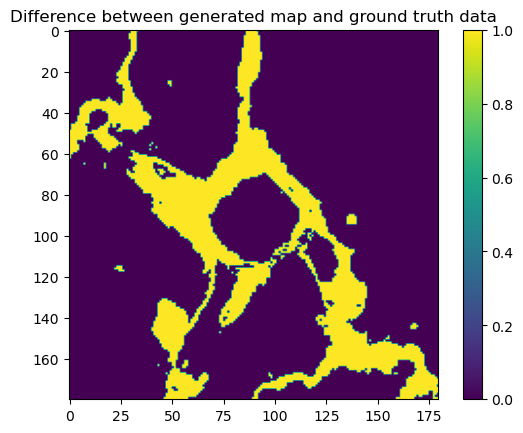

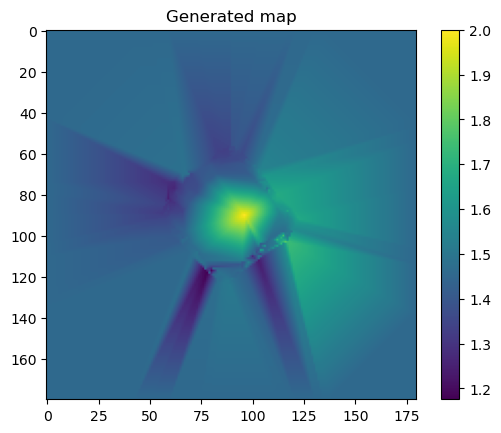

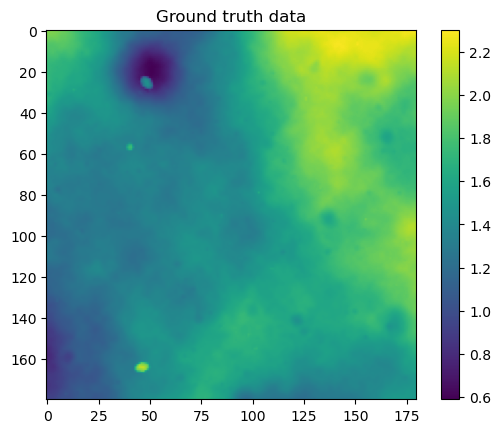

Mean squared error: 0.08469072976363369
Score: 103.9


In [4]:
mse, score = evaluate_interp(surfaceHeight._last_height_map, gt_data)
print('Mean squared error:', mse)
print('Score:', score)

# Filtered smoothing. 3 steps for interp_confidence.

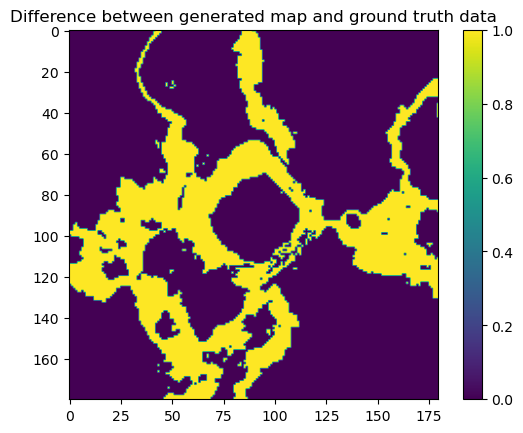

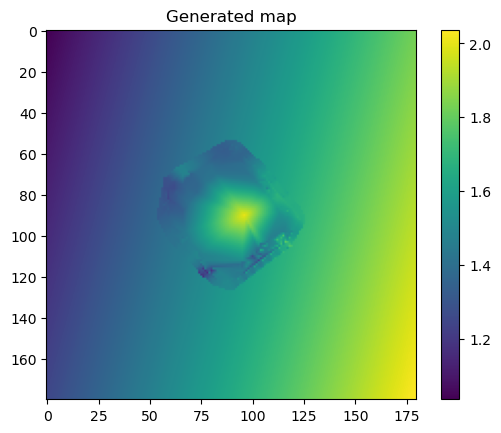

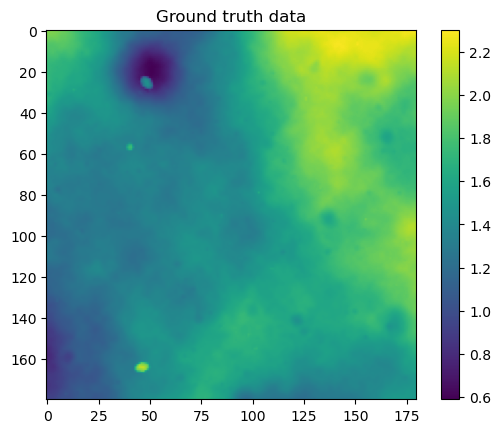

Mean squared error: 0.058839107014240645
Score: 143.83333333333334


In [4]:
mse, score = evaluate_interp(surfaceHeight._last_height_map, gt_data)
print('Mean squared error:', mse)
print('Score:', score)

# Mean

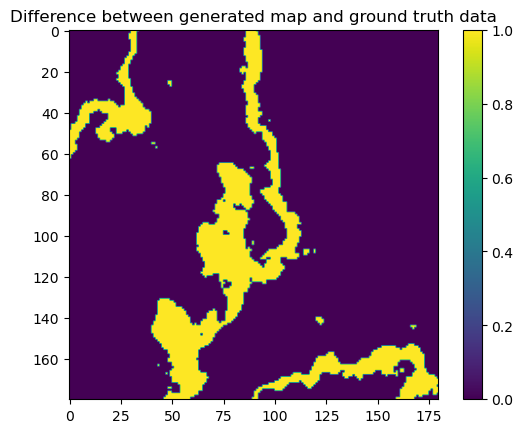

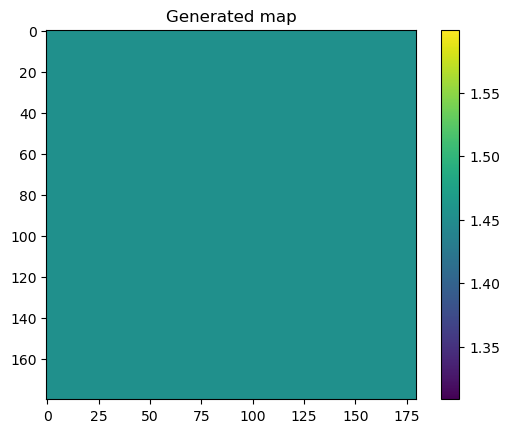

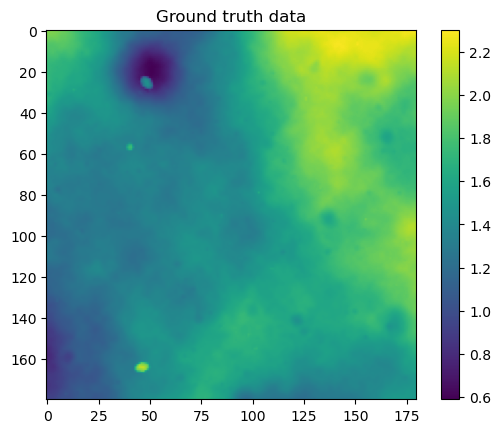

Mean squared error: 0.09231518118694163
Score: 76.18333333333334


In [6]:
mean_map = mean_all_sample_heights(data, gt_data)
mse, score = evaluate_interp(mean_map, gt_data)
print('Mean squared error:', mse)
print('Score:', score)

# Outlier Removal, filter size = 7

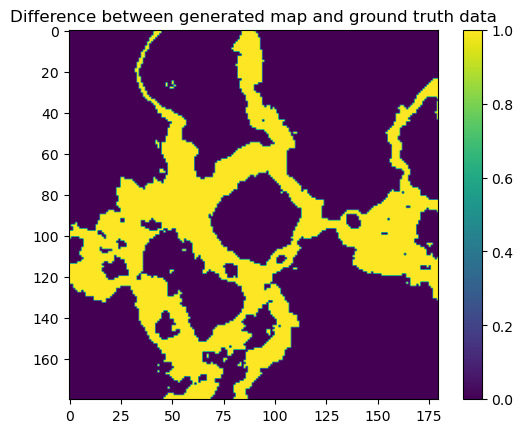

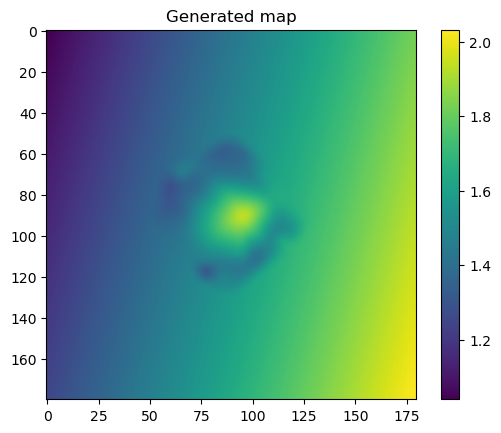

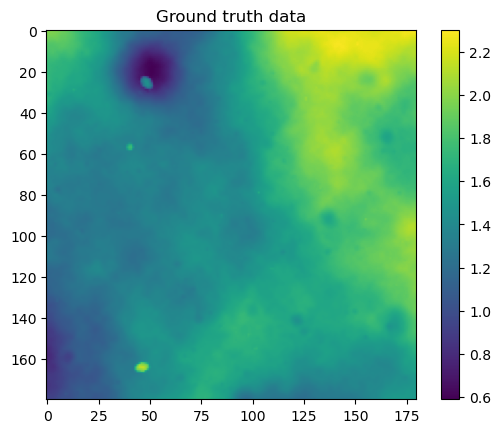

Mean squared error: 0.05855932302902421
Score: 145.71666666666667


In [4]:
mse, score = evaluate_interp(surfaceHeight._last_height_map, gt_data)
print('Mean squared error:', mse)
print('Score:', score)

# Outlier Removal, filter size = 3

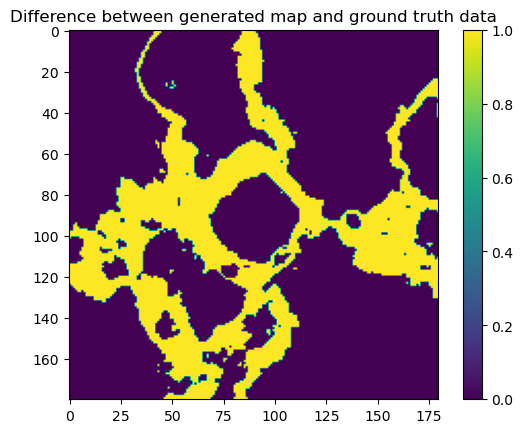

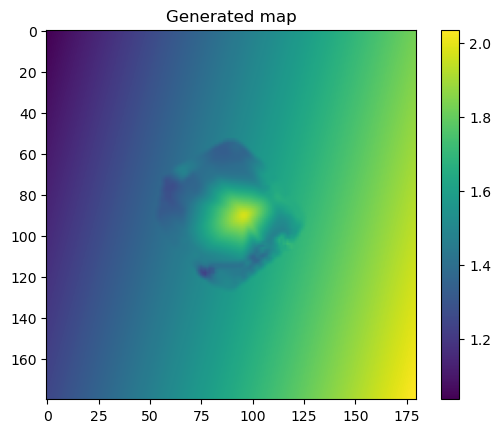

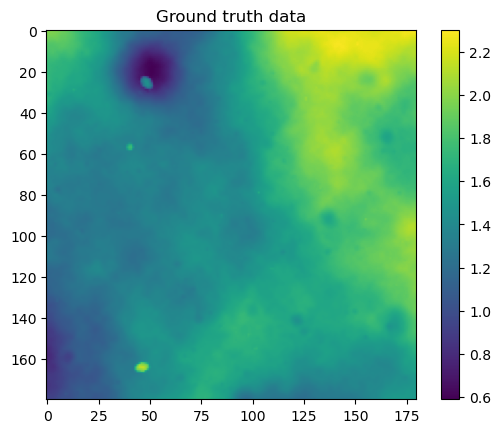

Mean squared error: 0.05874492097527739
Score: 145.08333333333334


In [4]:
mse, score = evaluate_interp(surfaceHeight._last_height_map, gt_data)
print('Mean squared error:', mse)
print('Score:', score)

# Mean Averaging

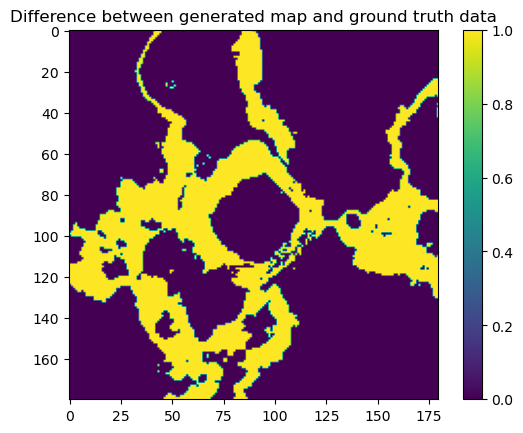

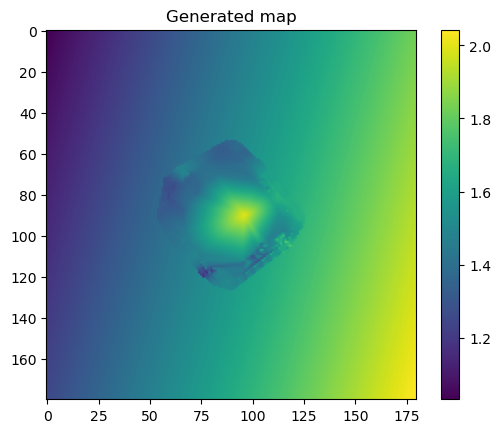

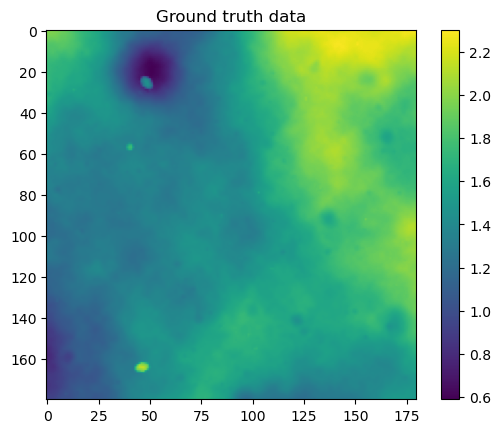

Mean squared error: 0.059394730630056826
Score: 143.7


In [7]:
mse, score = evaluate_interp(surfaceHeight._last_height_map, gt_data)
print('Mean squared error:', mse)
print('Score:', score)

# Outlier Removal

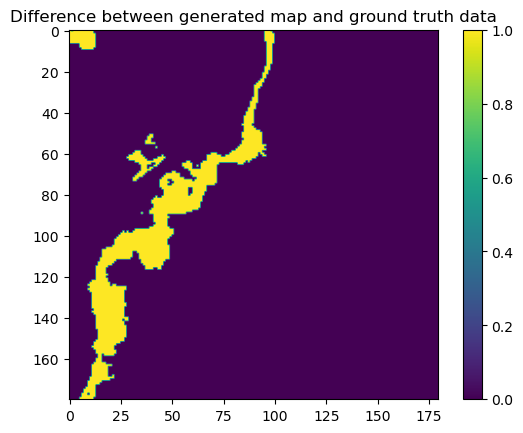

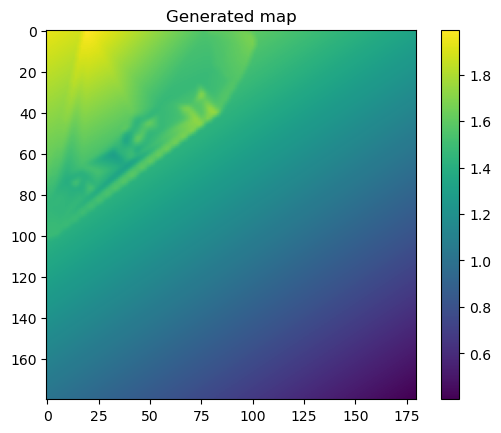

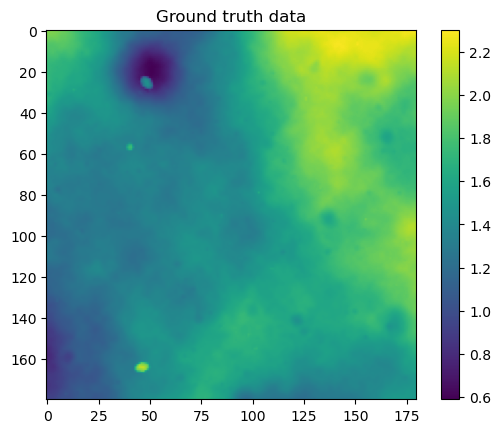

Mean squared error: 0.35221763289089025
Score: 39.45


In [90]:
mse, score = evaluate_interp(surfaceHeight._last_height_map, gt_data)
print('Mean squared error:', mse)
print('Score:', score)